In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import minilensmaker as mil

In [2]:
# Download and unzip the COSMOS data from https://zenodo.org/record/3242143
# then update the path below to point to the folder containing all the files.
catalog = mil.COSMOSCatalog('/mnt/e/Madhu/COSMOS_23.5_training_sample/COSMOS_23.5_training_sample')

# Select some nice galaxies

The COSMOS catalog contains many images. Some of these are 'bad' in various ways:
  * Some contain only a poiunt source. This isn't very interesting to reconstruct. 
  * Some have a very poor signal/noise, perhaps because the galaxy is far away (high redshift) or very faint (high magnitude).
  * Some have huge areas masked out (pixels set to zero) by a foreground star removal algorithm. Unfortunately this data  no longer has the details of which images were most affected by that algorithm...

We will experiment with different selections, or maybe make a manual 'blacklist'. This is a simple magnitude/redshift selection.

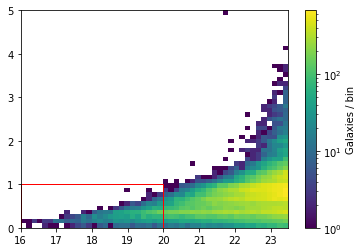

In [42]:
magnitude_range = (16, 20)
redshift_range = (0, 1)

x, y = catalog.catalog['mag_auto'], catalog.catalog['zphot'], 
plt.hist2d(x, y,
           bins=(np.linspace(16, 23.5, 50), np.linspace(0, 5, 50)), 
           norm=matplotlib.colors.LogNorm());
plt.colorbar(label='Galaxies / bin')

mil.draw_box(magnitude_range, redshift_range, edgecolor='r')

selection_mask = (
    (magnitude_range[0] <= x) & (x < magnitude_range[1])
    & (redshift_range[0] <= y) & (y < redshift_range[1]))

In [4]:
print(selection_mask.size)
print(selection_mask)
count = np.count_nonzero(selection_mask)
print(count)

56062
[False False False ... False False False]
2418


# Draw metadata

In [35]:
n_images = count * 10

md = dict()

# Index in the catalog of the galaxy image to use
md['source_index'] = catalog.sample_indices(n_images, selection_mask)

# Rotation (in radians) to give the source image
md['source_rotation'] = 2 * np.pi * np.random.rand(n_images)

# Einstein radius in arcseconds of the lens
md['theta_E'] = np.random.uniform(0.8, 1.2, n_images)

# Exponent of the lens's power-law mass distribution
md['gamma'] = 2 + 0.1 * np.random.randn(n_images)

# Ellipticity components of the lens
md['e1'], md['e2'] = np.random.uniform(-0.05, 0.05, (2, n_images))

# Location of the lens in the image, in arcseconds
md['center_x'], md['center_y'] = 0.2 * np.random.randn(2, n_images)

# External shear components
md['gamma1'], md['gamma2'] = 0.16 * np.random.randn(2, n_images)

md['fileName'] = np.arange(n_images)

# You can save this to csv, or whatever other output you prefer
csvfile= pd.DataFrame(md)
#csvfile["fileName"] = np.arange(csvfile.shape[0])
# file = "/mnt/e/Madhu/ProjectData/parameters.csv"


imageDict = csvfile.to_dict('records')

csvfile.head()
#np.save(file,csvfile)
#csvfile.to_csv (file, index = False, header=True)

,source_index,source_rotation,theta_E,gamma,e1,e2,center_x,center_y,gamma1,gamma2,fileName
0,2720,2.974740,0.896312,2.129647,-0.007939,-0.008398,0.134042,-0.290048,0.133187,-0.036522,0
1,34461,3.235396,1.198289,2.026151,-0.045114,-0.019775,-0.086834,-0.272532,-0.019896,0.132149,1
2,46666,5.749283,0.989821,1.933094,0.027792,-0.013456,-0.012319,-0.286107,-0.074430,-0.264630,2
3,10576,0.773577,0.988996,1.979358,-0.010125,-0.002919,0.674781,-0.061619,0.099844,-0.119436,3
4,2309,0.832937,0.819008,2.244781,0.039451,-0.029669,0.208221,0.012079,0.065658,-0.010765,4


In [36]:

np.unique(md['source_index']).size


2418

In [37]:
all_indices=np.unique(md['source_index'])

### Produce images

In [38]:
n = 200  # for 2 random indices
index_dev = np.random.choice(all_indices.shape[0], n, replace=False)  
dev_indices = all_indices[index_dev]
new_all_indices = np.delete(all_indices, index_dev)
index_test = np.random.choice(new_all_indices.shape[0], n, replace=False)  
test_indices = new_all_indices[index_test]
train_indices = np.delete(new_all_indices, index_test)
print("train: {} dev: {} test:  {}".format(train_indices.size,dev_indices.size,test_indices.size))
train_indices.size

train: 2018 dev: 200 test:  200


2018

In [39]:
lensmaker = mil.LensMaker(catalog=catalog, pixel_width=0.08)

In [40]:
plot = True
# A dummy 'lens' that does not lens at all.
no_lens = [('SIS', dict(theta_E=0))]

for i in range(n_images):

    source_kwargs = dict(
        catalog_i=md['source_index'][i], 
        phi=md['source_rotation'][i])
    
    unlensed_img = lensmaker.lensed_image(
        lenses=no_lens,
        **source_kwargs)
    
    lensed_img = lensmaker.lensed_image(
        lenses=[
            ('PEMD', {k: md[k][i] for k in 'theta_E gamma e1 e2 center_x center_y'.split()}),
            ('SHEAR', {k: md[k][i] for k in 'gamma1 gamma2'.split()})],
        **source_kwargs)
    # Save to file
    if(md['source_index'][i] in test_indices):
        path = "/mnt/e/Madhu/ProjectData/test"
    elif(md['source_index'][i] in dev_indices):
        path = "/mnt/e/Madhu/ProjectData/dev"
    else:
        path = "/mnt/e/Madhu/ProjectData/train"
                
    unlensed_img_name = "{}/Unlensed/{}.npy".format(path,md['fileName'][i])
    np.save(unlensed_img_name,unlensed_img)
    # Save to file
    lensed_img_name = "{}/Lensed/{}.npy".format(path,md['fileName'][i])
    np.save(lensed_img_name,lensed_img)
    # Here you would save these images in whatever format you prefer.
    # Be aware these images are now arrays of floats; most image formats are made of integers.
    # Unless you use a float-image format (or just save the numpy array),
    # you will either have to commit to some discretization and normalization here.
    plot = False
    if plot:
        f, axes = plt.subplots(ncols=2, figsize=(12, 4))
        
        plt.sca(axes[0])
        mil.plot_image(
            unlensed_img,
            lensmaker.pixel_width)
        plt.title("Unlensed")
        
        plt.sca(axes[-1])
        mil.plot_image(
            lensed_img,
            lensmaker.pixel_width)
        plt.title("Lensed")
        

### Train / Test/ Dev Split using unique sourceId

In [45]:
trainfile = "/mnt/e/Madhu/ProjectData/trainParameters.csv"
devfile = "/mnt/e/Madhu/ProjectData/devParameters.csv"
testfile = "/mnt/e/Madhu/ProjectData/testParameters.csv"
devpara= csvfile.loc[csvfile['source_index'].isin(dev_indices)]
devpara.to_csv (devfile, index = False, header=True)
testpara= csvfile.loc[csvfile['source_index'].isin(test_indices)]
testpara.to_csv (testfile, index = False, header=True)
trainpara= csvfile.loc[csvfile['source_index'].isin(train_indices)]
trainpara.to_csv (trainfile, index = False, header=True)
#np.save(file,csvfile)
#csvfile.to_csv (file, index = False, header=True)
trainpara

,source_index,source_rotation,theta_E,gamma,e1,e2,center_x,center_y,gamma1,gamma2,fileName
0,2720,2.974740,0.896312,2.129647,-0.007939,-0.008398,0.134042,-0.290048,0.133187,-0.036522,0
1,34461,3.235396,1.198289,2.026151,-0.045114,-0.019775,-0.086834,-0.272532,-0.019896,0.132149,1
2,46666,5.749283,0.989821,1.933094,0.027792,-0.013456,-0.012319,-0.286107,-0.074430,-0.264630,2
4,2309,0.832937,0.819008,2.244781,0.039451,-0.029669,0.208221,0.012079,0.065658,-0.010765,4
5,20627,4.150509,0.958982,1.935049,0.023052,0.028455,-0.018407,-0.243672,0.013548,0.096941,5
...,...,...,...,...,...,...,...,...,...,...,...
24175,8085,4.917573,0.881434,2.104400,-0.034017,0.044727,0.071738,-0.278314,-0.249222,-0.328943,24175
24176,11907,0.002730,1.158542,1.806199,-0.047069,0.000530,-0.292097,0.270716,-0.154953,0.050621,24176
24177,25835,3.718188,0.993682,1.902162,-0.014586,-0.025752,-0.402983,-0.199935,0.115692,0.021702,24177
24178,29176,4.100282,0.807907,2.030633,0.004522,-0.019899,-0.042271,-0.052721,0.112085,-0.001210,24178
